2.Detect Pokémon
==============

In order to detect Pokémon among images, we need to train a model with images of Pokémon and images of other classes.<br>
We will use transfer learning in order to speed up the training process.

Our problem is a classification with 2 classes: "Pokemon", "Other".

- "Pokemon" dataset represents the class "Pokemon"
- "CIFAR100" dataset represents the class "Other"

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim.lr_scheduler as lr_scheduler
import torchvision
from torch import optim, nn
from torch.utils.data import RandomSampler
from torchvision import models

In [2]:
import utils
import conf

In [3]:
transform, std_nums, mean_nums = utils.torch_transformations()

## Build dataset

In [4]:
pokemon_dataset = torchvision.datasets.ImageFolder('data/Pokemon', transform=transform['train'])

# Set class for each Pokemon to 0
pokemon_dataset.target_transform = lambda x: conf.detector_classes.index('Pokemon')

In [5]:
# Check class = 0 for every images : take random index
[(f'index={i}', f'class={pokemon_dataset[i][1]}') for i in np.random.randint(len(pokemon_dataset), size=5)]

[('index=2273', 'class=0'),
 ('index=685', 'class=0'),
 ('index=730', 'class=0'),
 ('index=5621', 'class=0'),
 ('index=279', 'class=0')]

In [6]:
pokemon_test_size = round((len(pokemon_dataset))*.15)
pokemon_train_size = len(pokemon_dataset) - pokemon_test_size

lengths=[round(len(pokemon_dataset) * 3/4), round(len(pokemon_dataset)* 1/4)]
pokemon_dataset_train, pokemon_dataset_test = torch.utils.data.random_split(pokemon_dataset, [pokemon_train_size, pokemon_test_size])
print('train size = %s ; test_size = %s ' % (len(pokemon_dataset_train), len(pokemon_dataset_test)))

train size = 5797 ; test_size = 1023 


In [7]:
cifar100_train = torchvision.datasets.CIFAR100(root='data/', train=True, download=True, transform=transform['train'])
cifar100_test = torchvision.datasets.CIFAR100(root='data/', train=False, download=True, transform=transform['test'])

Files already downloaded and verified
Files already downloaded and verified


In [8]:
# Set class for each image to 1
cifar100_train.target_transform = lambda x: conf.detector_classes.index('Other')
cifar100_test.target_transform = lambda x: conf.detector_classes.index('Other')

In [9]:
print('train size = %s ; test_size = %s ' % (len(cifar100_train), len(cifar100_test)))

RandomSampler(cifar100_train, replacement=True, num_samples=5000)
RandomSampler(cifar100_train, replacement=True, num_samples=1000)

print('train size = %s ; test_size = %s ' % (len(cifar100_train), len(cifar100_test)))

train size = 50000 ; test_size = 10000 
train size = 50000 ; test_size = 10000 


In [10]:
# Check class = 1 for every images : take random index
[(f'index={i}', f'class={cifar100_train[i][1]}') for i in np.random.randint(len(cifar100_train), size=5)]

[('index=40610', 'class=1'),
 ('index=36855', 'class=1'),
 ('index=30662', 'class=1'),
 ('index=124', 'class=1'),
 ('index=38746', 'class=1')]

In [11]:
RandomSampler(cifar100_train, replacement=True, num_samples=5000)
RandomSampler(cifar100_train, replacement=True, num_samples=1000)

In [12]:
pokemon_detector_train = torch.utils.data.ConcatDataset([pokemon_dataset_train, cifar100_train])
pokemon_detector_test = torch.utils.data.ConcatDataset([pokemon_dataset_test, cifar100_test])

In [13]:
batch_size = 16

pokemon_detector_loader_train = torch.utils.data.DataLoader(pokemon_detector_train,
                                     batch_size, shuffle=True, drop_last=True)
pokemon_detector_loader_test = torch.utils.data.DataLoader(pokemon_detector_test,
                                     batch_size, shuffle=True)

In [14]:
len(pokemon_detector_loader_train)

3487

In [15]:
for i in range(2):
    batch_x, batch_y = next(iter(pokemon_detector_loader_train))
    print(np.shape(batch_x), batch_y)

torch.Size([16, 3, 64, 64]) tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1])
torch.Size([16, 3, 64, 64]) tensor([1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0])


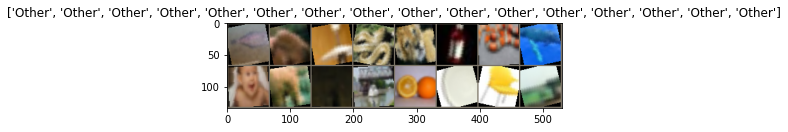

In [16]:
# Get a batch of training data
inputs, classes = next(iter(pokemon_detector_loader_train))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

utils.imshow_tensor(out, std_nums, mean_nums, title=[conf.detector_classes[x] for x in classes])

In [17]:
data_loaders = {
    'train': pokemon_detector_loader_train,
    'val': pokemon_detector_loader_test
}
dataset_sizes = {
    'train': len(pokemon_detector_loader_train),
    'val': len(pokemon_detector_loader_test)
}

## Prototype model Transfer learning

### ConvNet as fixed feature extractor

We freeze the network and set the last with 2 outputs for our 2 classes.

In [18]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('cpu')

model_conv = models.resnet50(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = utils.train_model(model_conv, data_loaders, dataset_sizes, criterion, optimizer_conv,
                         exp_lr_scheduler, device, num_epochs=1)

In [19]:
PATH = './pokemon_detector.pth'

torch.save(model_conv, PATH)

In [20]:
model_conv = torch.load(PATH)

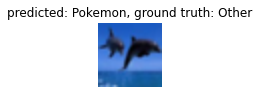

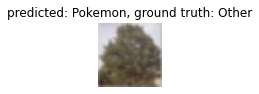

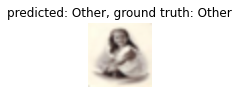

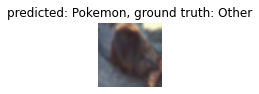

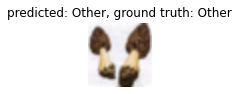

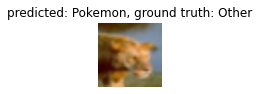

In [21]:
utils.visualize_model(model_conv, data_loaders, conf.detector_classes, std_nums, mean_nums, device, num_images=6)

plt.ioff()
plt.show()

  0%|          | 0/689 [00:00<?, ?it/s]

Accuracy of the network on the test images: 31 %


100%|██████████| 689/689 [04:09<00:00,  2.77it/s]


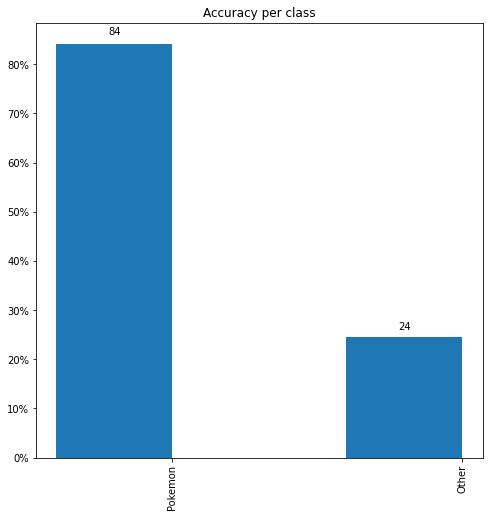

In [22]:
utils.test_accuracy(model_conv, pokemon_detector_loader_test, conf.detector_classes, figsize=(8, 8))

### Interpretation

Our model is not yet accurate, it is fine because we trained it only during 1 epoch

## Train with SageMaker
Now that our model runs without errors, we will train it on AWS GPU using SageMaker

We will use `sources_detector` directory as `source_dir` where can find the [train.py](source_detector/train.py)

Training script workflow:
- Loads training data:
    - Pokemon data from local dir
    - CIFAR100 is downloaded with `torchvision.datasets.CIFAR100(root=data_dir, download=True, ...)`
- Build the training and validation datasets concatenating Pokemon and CIFAR100 datasets
- Parses any training & model hyperparameters (ex. nodes in a neural network, training epochs, etc.)
- Instantiates ResNet50 model pretrained: `models.resnet50(pretrained=True)`
- Configure output layer with 2 neurons
- Trains that model and at each epoch saves the better model
- Finally, saves the best model so that it can be hosted/deployed, later

In [27]:
import sagemaker
import boto3
from sagemaker.pytorch import PyTorch
from sagemaker.local import LocalSession

### Local Mode with 1 epoch


In [28]:
sagemaker_session = LocalSession(boto3.session.Session(region_name='us-east-1'))
sagemaker_session.config = {'local': {'local_code': True}}
# session and role
role = sagemaker.get_execution_role()

# create an S3 bucket
bucket = sagemaker_session.default_bucket()

ValueError: Must setup local AWS configuration with a region supported by SageMaker.

In [ ]:
output_path = f'file://output_detector'

estimator = PyTorch(entry_point='train.py',
                   source_dir='/home/ec2-user/SageMaker/pokemon_classifier/source_detector',
                    framework_version='1.6',
                    py_version='py3',
                   role=role,
                   instance_count=1,
                   instance_type='local',
                   output_path=output_path,
                    sagemaker_session=sagemaker_session,
                   hyperparameters={
                        'epochs': 1, # could change to higher
                       'batch-size': 32
                    })

In [ ]:
estimator.fit({'train': 'file://data'})

### Train on GPU with 60 epochs

In [ ]:
sagemaker_session = sagemaker.Session()

In [ ]:
# should be the name of directory you created to save your features data
data_dir = 'data'

# set prefix, a descriptive name for a directory  
prefix = 'train_data_pokemon_detector'

# upload all data to S3
input_data = sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)
print(input_data)

In [ ]:
output_path = f's3://{bucket}/pokemon_detector/output'

estimator = PyTorch(entry_point='train.py',
                   source_dir='source_detector',
                    framework_version='1.6',
                    py_version='py3',
                   role=role,
                   instance_count=1,
                   instance_type='ml.p2.xlarge',
                   output_path=output_path,
                    sagemaker_session=sagemaker_session,
                   hyperparameters={
                        'epochs': 80 # could change to higher
                    })

In [ ]:
%%time

# Train your estimator on S3 training data
estimator.fit({'train': input_data})